In [327]:
import fragmentAndSimulate as fas
import calcIsotopologues as ci
import pandas as pd

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [328]:
def MPADataframe(deltas):
    IDList = ['Ccarbon','Hmethyl','Hother']
    elIDs = ['C','H','H']
    numberAtSite = [1,3,2]

    l = [elIDs, numberAtSite, deltas]
    cols = ['IDS','Number','deltas']

    molecularDataFrame = pd.DataFrame(l, columns = IDList)
    molecularDataFrame = molecularDataFrame.transpose()
    molecularDataFrame.columns = cols

    return molecularDataFrame

In [329]:
def calcComparison(deltaMethylSmp, deltaMethylStd, deltaHydroxylSolvent, deltaHydroxylAtmo):
    MPAStd = MPADataframe([-30,deltaMethylStd, deltaHydroxylSolvent])
    byAtomStdOrbi = ci.inputToAtomDict(MPAStd, disable = True)

    MPASmp = MPADataframe([-30, deltaMethylSmp, deltaHydroxylSolvent])
    byAtomSmpOrbi = ci.inputToAtomDict(MPASmp, disable = True)

    UValStdPartial = (1/2 * byAtomStdOrbi['000001']['Conc'] + byAtomStdOrbi['000100']['Conc']) / byAtomStdOrbi['000000']['Conc']
    UValSmpPartial = (1/2 * byAtomSmpOrbi['000001']['Conc'] +  byAtomSmpOrbi['000100']['Conc']) / byAtomSmpOrbi['000000']['Conc']
    deltaComparisonOrbi = 1000 * (UValSmpPartial / UValStdPartial - 1)

    MPAStd = MPADataframe([-30,deltaMethylStd, deltaHydroxylAtmo])
    byAtomStdEA = ci.inputToAtomDict(MPAStd, disable = True)

    MPASmp = MPADataframe([-30, deltaMethylSmp, deltaHydroxylAtmo])
    byAtomSmpEA = ci.inputToAtomDict(MPASmp, disable = True)

    UValStdFull = (byAtomStdEA['000001']['Conc'] + byAtomStdEA['000100']['Conc']) / byAtomStdEA['000000']['Conc']
    UValSmpFull = (byAtomSmpEA['000001']['Conc'] + byAtomSmpEA['000100']['Conc']) / byAtomSmpEA['000000']['Conc']
    deltaComparisonFull = 1000 * (UValSmpFull / UValStdFull - 1)

    UValStdMethyl = (byAtomStdOrbi['000100']['Conc']) / byAtomStdOrbi['000000']['Conc']
    UValSmpMethyl = (byAtomSmpOrbi['000100']['Conc']) / byAtomSmpOrbi['000000']['Conc']
    deltaComparisonMethyl = 1000 * (UValSmpMethyl / UValStdMethyl - 1)

    return deltaComparisonOrbi, deltaComparisonFull, deltaComparisonMethyl

In [352]:
def calcComparison(deltaMethylSmp, deltaMethylStd, deltaHydroxylSolvent):
    MPAStd = MPADataframe([-30,deltaMethylStd, deltaHydroxylSolvent])
    byAtomStdOrbi = ci.inputToAtomDict(MPAStd, disable = True)

    MPASmp = MPADataframe([-100, deltaMethylSmp, deltaHydroxylSolvent])
    byAtomSmpOrbi = ci.inputToAtomDict(MPASmp, disable = True)

    UValStdPartial = (1/2 * byAtomStdOrbi['000001']['Conc'] + byAtomStdOrbi['000100']['Conc']) / byAtomStdOrbi['000000']['Conc']
    UValSmpPartial = (1/2 * byAtomSmpOrbi['000001']['Conc'] +  byAtomSmpOrbi['000100']['Conc']) / byAtomSmpOrbi['000000']['Conc']
    deltaComparisonOrbi = 1000 * (UValSmpPartial / UValStdPartial - 1)

    UValStdMethyl = (byAtomStdOrbi['000100']['Conc']) / byAtomStdOrbi['000000']['Conc']
    UValSmpMethyl = (byAtomSmpOrbi['000100']['Conc']) / byAtomSmpOrbi['000000']['Conc']
    deltaComparisonMethyl = 1000 * (UValSmpMethyl / UValStdMethyl - 1)

    return deltaComparisonOrbi, deltaComparisonMethyl

In [366]:
allDelOrbi = []
allDelMethyl = []
allConst = []
smpDelta = list(range(-400,350,100))
stdDelta = list(range(-250,-125,25))

for smpD in smpDelta:
    thisDelOrbi = []
    thisDelMethyl = []
    thisC = []
    for stdD in stdDelta:
        comp = calcComparison(smpD, stdD, -200)
        if comp[0] == 0:
            print(comp[1])
        thisDelOrbi.append(comp[0])
        thisDelMethyl.append(comp[1])
        thisC.append(comp[1] / comp[0])

    allDelOrbi.append(thisDelOrbi)
    allDelMethyl.append(thisDelMethyl)
    allConst.append(thisC)


In [367]:
allConst

[[1.3555555555555572,
  1.3440860215053771,
  1.3333333333333341,
  1.3232323232323235,
  1.3137254901960782],
 [1.355555555555559,
  1.3440860215053774,
  1.333333333333335,
  1.3232323232323244,
  1.3137254901960789],
 [1.3555555555555538,
  1.3440860215053831,
  1.0,
  1.3232323232323262,
  1.313725490196078],
 [1.3555555555555536,
  1.3440860215053758,
  1.3333333333333326,
  1.3232323232323218,
  1.3137254901960813],
 [1.3555555555555552,
  1.3440860215053765,
  1.3333333333333333,
  1.3232323232323226,
  1.31372549019608],
 [1.3555555555555556,
  1.3440860215053783,
  1.3333333333333344,
  1.323232323232324,
  1.3137254901960804],
 [1.3555555555555554,
  1.3440860215053765,
  1.3333333333333333,
  1.3232323232323235,
  1.3137254901960789],
 [1.3555555555555552,
  1.3440860215053771,
  1.3333333333333333,
  1.3232323232323229,
  1.3137254901960793]]

In [362]:
MPAStd = MPADataframe([-100,-150, -74])
byAtomStdOrbi = ci.inputToAtomDict(MPAStd, disable = True)

MPASmp = MPADataframe([-70, -150, -74])
byAtomSmpOrbi = ci.inputToAtomDict(MPASmp, disable = True)

In [363]:
byAtomSmpOrbi['000000']['Conc'] / byAtomStdOrbi['000000']['Conc']

0.9996680514023493

c:\Users\tacse\Anaconda3\envs\Orbitrap\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


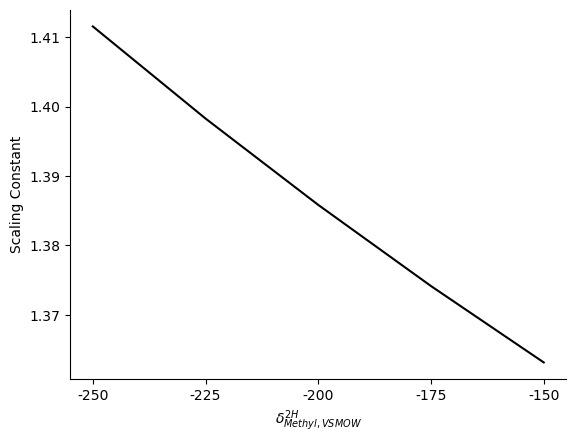

In [333]:
fig, ax = plt.subplots()

ax.plot(allConst[0], c = 'k')


ax.set_ylabel("Scaling Constant")

ax.set_xticklabels([str(x) for x in stdDelta])
ax.set_xticks(list(range(len(stdDelta))))
ax.set_xlabel("$\delta^{2H}_{Methyl,VSMOW}$")

sns.despine()

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (8).

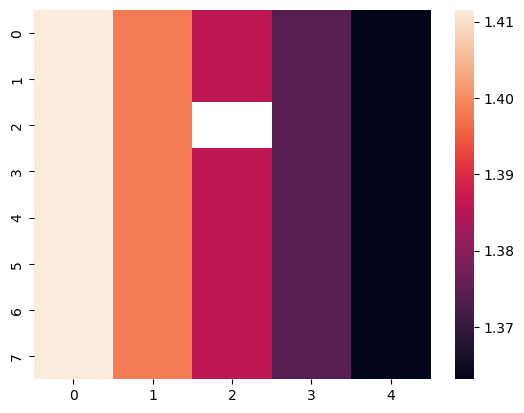

In [334]:
fig, ax = plt.subplots()

ax = sns.heatmap(allConst)

ax.set_xticklabels([str(x) for x in smpDelta])
ax.set_yticklabels([str(y) for y in stdDelta])
ax.set_xlabel("Delta VSMOW Methyl Sample")
ax.set_ylabel("Delta VSMOW Methyl Standard")

In [335]:
allDelOrbi = []
allDelMethyl = []
allConst = []
smpDelta = list(range(-250,350,100))
stdDelta = list(range(-250,-50,25))

for stdD in stdDelta:
    thisDelOrbi = []
    thisDelMethyl = []
    thisC = []
    for smpD in smpDelta:
        comp = calcComparison(smpD, stdD, -74,-159)
        if comp[0] == 0:
            print(comp[2])
        thisDelOrbi.append(comp[0])
        thisDelMethyl.append(comp[2])
        thisC.append(comp[2] / comp[0])

    allDelOrbi.append(thisDelOrbi)
    allDelMethyl.append(thisDelMethyl)
    allConst.append(thisC)


0.0


c:\Users\tacse\Anaconda3\envs\Orbitrap\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


0.0


In [343]:
(np.array(thisDelMethyl) / 1000) / (np.array(thisDelOrbi) / 1000)

array([1.33369369, 1.33369369, 1.33369369, 1.33369369, 1.33369369,
       1.33369369])

In [345]:
np.array(thisDelMethyl) / 1000 +  1

array([0.81081081, 0.91891892, 1.02702703, 1.13513514, 1.24324324,
       1.35135135])

In [346]:
(np.array(thisDelMethyl) / 1000 +  1) / (np.array(thisDelOrbi) / 1000 + 1)

array([0.94483968, 0.97840015, 1.00662792, 1.03070047, 1.0514724 ,
       1.06957899])

Text(50.722222222222214, 0.5, 'Delta VSMOW Methyl Standard')

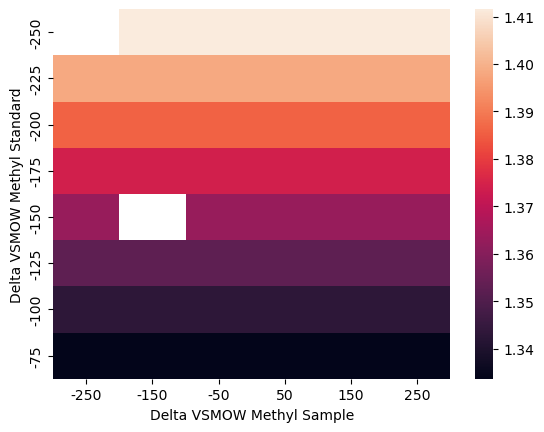

In [337]:
fig, ax = plt.subplots()

ax = sns.heatmap(allConst)

ax.set_xticklabels([str(x) for x in smpDelta])
ax.set_yticklabels([str(y) for y in stdDelta])
ax.set_xlabel("Delta VSMOW Methyl Sample")
ax.set_ylabel("Delta VSMOW Methyl Standard")

In [ ]:
def calcSmpMet(smpStdOrbi, stdMetDelta, bothHydoxyl):
    '''
    Assume:
        1) We know the sample standard comparison we get from the Orbitrap
        2) We know the content of the methyl group of the standard
        3) We know the value of the hydroxyl site

    Then compute:
        4) The content of the methyl group of the sample
    '''
    #Get delta value of entire standard
    stdMetC = op.deltaToConcentration('H',stdMetDelta)
    stdHydroxyC = op.deltaToConcentration('H',bothHydoxyl)
    stdCTotal = tuple([(3*stdMetC[i] + stdHydroxyC[i])/4 for i in range(len(stdMetC))])
    op.ratioToDelta('H',op.concentrationToM1Ratio(stdCTotal))

    #Use this to compute the ratio of the entire sample
    smpTotalR = (smpStdOrbi/1000 + 1) * op.concentrationToM1Ratio(stdCTotal)
    #and the concentration of the entire smaple 
    smpTotalC = op.deltaToConcentration('H',op.ratioToDelta('H',smpTotalR))

    #Subtract out concentration of the hydroxyl site
    smpSumC = tuple([4 * x for x in smpTotalC])
    smpHydroxylC = op.deltaToConcentration('H', -74)
    smpMetC = tuple([(smpSumC[i] - smpHydroxylC[i]) / 3 for i in range(len(smpHydroxylC))])

    #Get the delta value of the methyl site of the sample
    smpMetDelta = op.ratioToDelta('H',op.concentrationToM1Ratio(smpMetC))

    #Report the comparison
    smpStdMetDelta = op.compareRelDelta('H', stdMetDelta, smpMetDelta)
    return smpStdMetDelta

In [ ]:
stdDelta = list(range(-350,-50,50))
smpStdComp = list(range(-250, 350, 100))
allL = []

for smpStd in smpStdComp:
    thisL = []
    for stdD in stdDelta:
        thisL.append(calcSmpMet(smpStd, stdD, -74))
    allL.append(thisL)

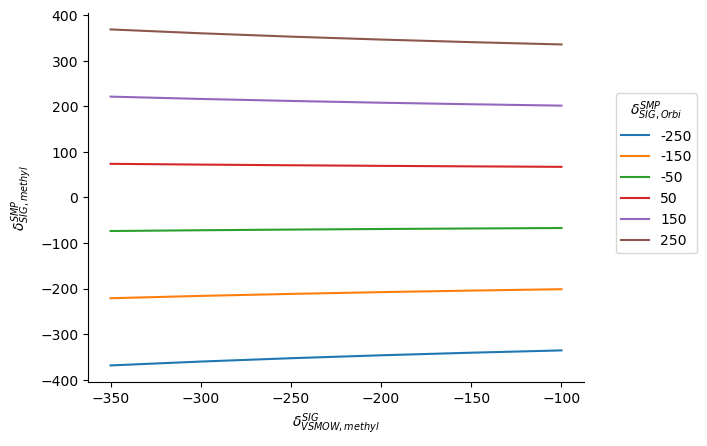

In [ ]:
fig, ax = plt.subplots()

for idx, thisSmpStd in enumerate(allL):
    ax.plot(stdDelta, thisSmpStd, label = str(smpStdComp[idx]))

ax.set_ylabel("$\delta^{SMP}_{SIG,methyl}$")
ax.set_xlabel("$\delta^{SIG}_{VSMOW,methyl}$")

leg = ax.legend(bbox_to_anchor = [1.05, 0.8])
leg.set_title('$\delta^{SMP}_{SIG,Orbi}$')

sns.despine()

In [ ]:
allL = []
for nonExchContr in np.arange(2,2.5, 0.01):
    thisL = []
    for atmoComp in range(-160, 20, 20):
        observed = -160

        observedC = op.deltaToConcentration('H',observed)
        atmoC = op.deltaToConcentration('H',atmoComp)

        methylC = tuple([(5*observedC[i] - nonExchContr*atmoC[i]) / 5 for i in range(len(observedC))])
        delta = op.ratioToDelta('H',op.concentrationToM1Ratio(methylC))
        thisL.append(delta)

    allL.append(thisL)

<AxesSubplot:>

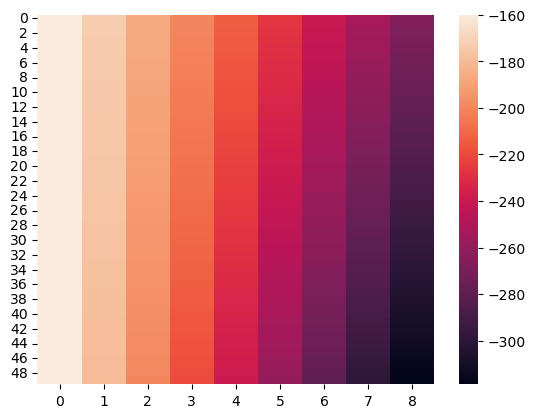

In [ ]:
sns.heatmap()

In [ ]:
smpTotalC

(0.999836868251127, 0.00016313174887299542, 0, 0)

In [ ]:
smpTotalC

(0.999836868251127, 0.00016313174887299542, 0, 0)

In [ ]:
allDelOrbi

[[0.0,
  -23.069824669332164,
  -45.099218280216455,
  -66.15701264334007,
  -86.30609896432684,
  -105.60405519571958,
  -124.10369553226697,
  -141.85355309375848],
 [94.45843828715361,
  69.20947400799781,
  45.09921828021657,
  22.052337547780134,
  0.0,
  -21.120811039143984,
  -41.367898510755616,
  -60.79437989732517],
 [188.916876574307,
  161.4887726853278,
  135.29765484064927,
  110.26168773890022,
  86.30609896432651,
  63.362433117431394,
  41.36789851075551,
  20.26479329910802],
 [283.3753148614606,
  253.76807136265776,
  225.49609140108217,
  198.47103793002051,
  172.61219792865344,
  147.84567727400687,
  124.10369553226674,
  101.32396649554143],
 [377.8337531486142,
  346.04737003998775,
  315.69452796151506,
  286.6803881211406,
  258.9182968929802,
  232.3289214305826,
  206.83949255377797,
  182.38313969197483],
 [472.29219143576785,
  438.32666871731794,
  405.892964521948,
  374.88973831226093,
  345.2243958573069,
  316.81216558715806,
  289.5752895752892,
  

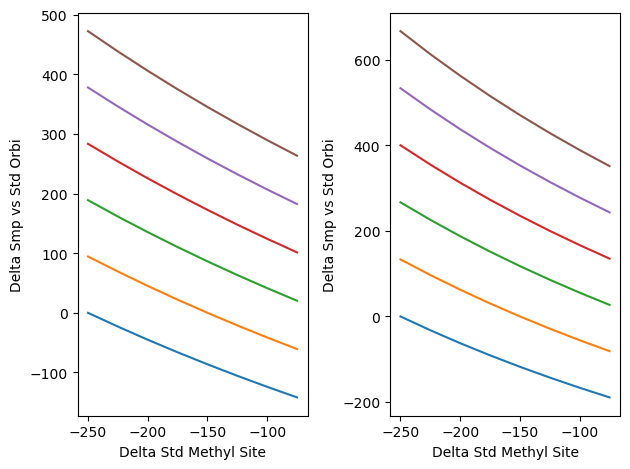

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)

cAx = axes[0]
for thisStdIdx in range(len(allDelOrbi)):
    cAx.plot(stdDelta, allDelOrbi[thisStdIdx])

cAx.set_ylabel("Delta Smp vs Std Orbi")
cAx.set_xlabel("Delta Std Methyl Site")

cAx = axes[1]
for thisStdIdx in range(len(allDelOrbi)):
    cAx.plot(stdDelta, allDelMethyl[thisStdIdx])

cAx.set_ylabel("Delta Smp vs Std Orbi")
cAx.set_xlabel("Delta Std Methyl Site")

plt.tight_layout()

In [ ]:
allConst[1]

[1.3982795698924881,
 nan,
 1.3982795698924624,
 1.3982795698924713,
 1.3982795698924664,
 1.3982795698924713,
 1.3982795698924708,
 1.3982795698924715,
 1.3982795698924702,
 1.3982795698924704,
 1.3982795698924704,
 1.3982795698924726,
 1.3982795698924722,
 1.3982795698924722,
 1.3982795698924728,
 1.3982795698924728,
 1.3982795698924728,
 1.3982795698924737,
 1.3982795698924722,
 1.398279569892472,
 1.3982795698924717,
 1.3982795698924722,
 1.3982795698924728,
 1.3982795698924735]

Text(50.722222222222214, 0.5, 'Delta VSMOW Methyl Standard')

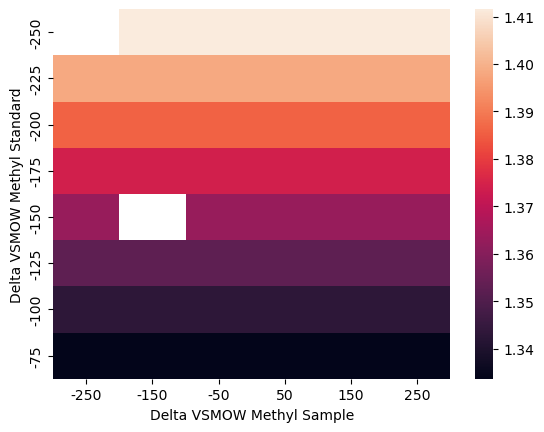

In [ ]:
allComp = []
hydroxylSolv = list(range(-250,50,25))
hydroxylAtmo = list(range(-250,50,25))

for dHydroxylSolv in hydroxylSolv:
    thisL = []
    for dHydoxylAtmo in hydroxylAtmo:
        comp = calcComparison(-150, -159, dHydroxylSolv,dHydoxylAtmo)
        thisL.append(comp[2] / comp[0])

    allComp.append(thisL)


In [ ]:
nonExchContL = list(np.arange(2,2.5, 0.1))
atmoCompL = list(range(-160,-60,20))

allL = []
for nonExchContr in nonExchContL:
    thisL = []
    for atmoComp in atmoCompL:
        observedC = op.deltaToConcentration('H',-159.6)
        atmoC = op.deltaToConcentration('H',atmoComp)

        methylC = tuple([(5*observedC[i] - nonExchContr*atmoC[i]) / 5 for i in range(len(observedC))])
        deltaMet = op.ratioToDelta('H',op.concentrationToM1Ratio(methylC))
        smpStdMet = op.compareRelDelta('H', -159.6, deltaMet)

        thisL.append((deltaMet))

    allL.append(thisL)

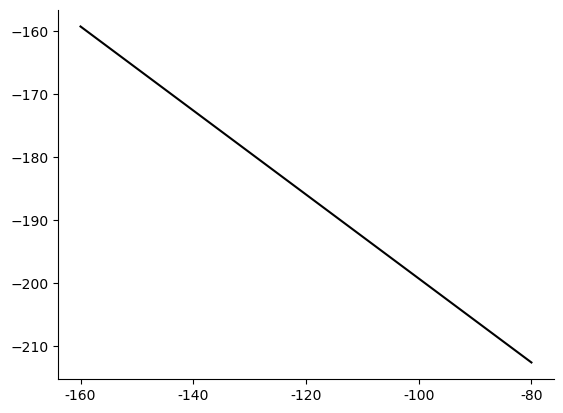

In [ ]:
fig, ax = plt.subplots()

ax.plot(range(len(allL[0])), allL[0], c = 'k')

ax.set_xticks(range(len(allL[0])))
ax.set_xticklabels(atmoCompL)

ax.set_xlabel("")

sns.despine()

c:\Users\tacse\Anaconda3\envs\Orbitrap\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


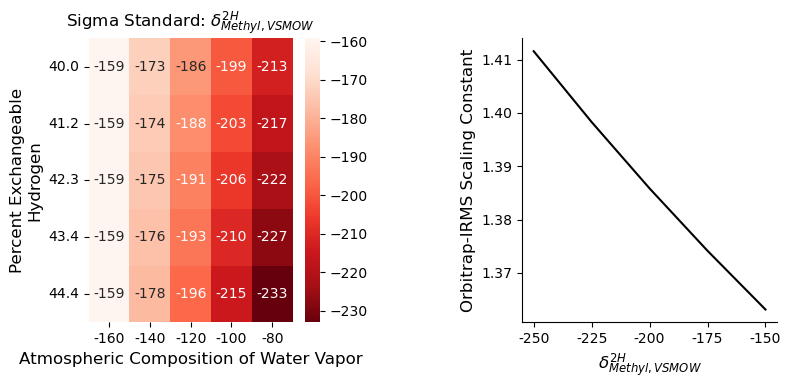

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

cAx = axes[0]
cAx = sns.heatmap(allL, ax = cAx, annot=True,fmt=".0f", cmap = 'Reds_r')

ytickLabs = [100 * x / (x + 3) for x in nonExchContL]
ytickLabs = [f'{x:.1f}' for x in ytickLabs]

cAx.set_xticklabels([str(x) for x in atmoCompL])
cAx.set_yticklabels(ytickLabs, rotation = 0)

cAx.set_ylabel ("Percent Exchangeable\nHydrogen", fontsize = 12)
cAx.set_xlabel("Atmospheric Composition of Water Vapor", fontsize = 12)

cAx.set_title("Sigma Standard: $\delta^{2H}_{Methyl, VSMOW}$")

cAx = axes[1]

cAx.plot(allConst[0], c = 'k')


cAx.set_ylabel("Orbitrap-IRMS Scaling Constant", fontsize = 12)

cAx.set_xticklabels([str(x) for x in stdDelta])
cAx.set_xticks(list(range(len(stdDelta))))
cAx.set_xlabel("$\delta^{2H}_{Methyl,VSMOW}$", fontsize = 12)

cAx.spines['right'].set_visible(False)
cAx.spines['top'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.7)